[#21.Lab]
- 다른 사람들이 어떤식으로 하이퍼파라미터를 설정했는지 깃허브를 통해 참고해서 가져오는 것 추천, 여러 DL Function이나 기술도 어느 자리에 넣어야 하는지도 보고.


- receptive field: 각각의 뉴런이 얼마나 큰 이미지를 보고 있는지
만약 1 x 1이면, 전체 이미지를 다 보고 있다는 의미


In [1]:
!mkdir results

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

# 1. Data Preparation

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

partition = {'train': trainset, 'val':valset, 'test':testset}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 2. Model Architecture
* torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

    Dimension: Input(N,Cin, Hin, Win) / Output(N, Cout, Hout, Wout) --> N = batch size, C = channel = Depth

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            

In [5]:
# 'M' = Maxpooling 
# num of filter
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [6]:
class CNN(nn.Module):       # Based on VGG      # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()             # 상속을 받았기 때문에 super함수를 통해 부모 클래스에 init 함수 실행
        
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError("Not a calid activation function code")
        
        self.layers = self._make_layers(model_code, in_channels, use_bn)        # 변수명 앞에 '_'를 먼저 붙이면 private 변수명이라는 것
                                                                                # Private 변수명이란 밖에서 호출을 못한다는 것

        # self.linear = nn.Linear(512, 10)        # Classification
        self.classifier = nn.Sequential(nn.Linear(512, 256), self.act, nn.Linear(256, out_dim))         # sub model

    def forward(self, x):
        x = self.layers(x)          # torch.Size([2, 512, 1, 1]), layers(x)도 하나의 model임
        x = x.view(x.size(0), -1)   # view를 통해 펴주는 역할
        x = self.classifier(x)      # torch.Size([2, 10])
        return x
    
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]           # size를 절반으로 줄임
            else:
                layers += [nn.Conv2d(in_channels = in_channels, out_channels = x, kernel_size = 3, stride = 1, padding = 1)]

                if use_bn:
                    layers += [nn.BatchNorm2d(x)]

                layers += [self.act]
                in_channels = x                     # out_channels가 다음 in_channels가 되어야 하므로 값을 업데이트 하는 부분을 추가해주어야함
            
        return nn.Sequential(*layers)               # *: Python 문법으로 layers 안에 있는 각각의 파라미터로 넣어줌, 하나의 model을 return

In [7]:
# torch.nn: https://pytorch.org/docs/stable/nn.html
class CNN1(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Conv Layer를 통과하더라도 사이즈가 H, W가 변하기 않기 위해 padding = 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 5, stride = 1, padding = 2)  # padding = dimension을 유지하기 위해 kernel size를 2를 나눈 몫으로 지정
        self.act = nn.ReLU()   
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)       # kernel_size = filter size, size를 절반으로

        self.fc = nn.Linear(65536, 10)  # (view에서 1차원으로 펴준 값(input), 10 classification)


    def forward(self, x):           # torch.Size([2, 3, 32, 32])
        x = self.conv1(x)
        x = self.act(x)             # torch.Size([2, 64, 32, 32]) = (batch size: 유지됨, channel: conv에서 지정한 fiter 갯수, 나머지도 유지됨)  
        x = self.conv2(x)
        x = self.act(x)             # torch.Size([2, 256, 32, 32])  --> output을 256으로 지정했고 size 유지를 위해 padding을 2로 지정했기 때문
        x = self.maxpool1(x)        # torch.Size([2, 256, 16, 16])  --> maxpooling을 통해 size를 반으로 조정했기 때문
        x = x.view(x.size(0), -1)   # torch.Size([2, 65536]) --> 4차원으로 출력된 Conv output을 1차원으로 펴줘야 FC Layer 적용이 되므로 view를 통해 size조정해 줘야함
        x = self.fc(x)              # torch.Size([2, 10])

        return x

In [10]:
# def dimension_check():    # model CNN1()      basic CNN
#     net = CNN()
#     x = torch.randn(2, 3, 32, 32)         # size에 맞게 랜덤 값을 생성
#     y = net(x)
#     print(y.size())

# dimension_check()       # torch.Size([2, 256, 32, 32]) = (batch size: 유지됨, channel: conv에서 지정한 fiter 갯수, 나머지도 유지됨)   

def dimension_check():      # model CNN()       VGG
    net = CNN('VGG11', 3, 10, 'relu', 'use_bn')
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.size())     # torch.Size([2, 512, 1, 1])    --> 512: 전체 이미지를 보고 뽑아낸 고차원적이고 복잡한 Feature 갯수를 512 만큼 뽑아내겠다
                                                    #   --> 그리고 이 512 Feature를 Linear Layer에 넣어서 10개의 classifiaction을 하겠다는 뜻
dimension_check()

torch.Size([2, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 3-1. Train

In [11]:
def train(net, partition, optimizer, criterion, args):
    # dictionary partition안의 train으로 trainset를 불러들임
    trainloader = torch.utils.data.DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정

        # get the inputs
        inputs, labels = data

        # size(): 항상 데이터를 구성하는 차원의 순서가 어떻게 되어 있는지 파악해야함.
        # print(inputs.size())      # torch.Size([256, 3, 32, 32]) = (batch size, num of channel(RGB), hieght, width) --> 4차원 Tensor임을 확인할 수 있음
        # raise RuntimeError        # 하나만 출력해서 보기 위한 에러 생성
        # inputs = inputs.view(-1, 3072)    # MLP는 모든 픽셀을 1차원 일자로 쭉 펴줘야 하기 떄문에 view를 사용했지만 CNN은 그럴 필요가 없으므로 주석처리

        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

# 3-2. Validate

In [12]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

# 3-3. Test

In [13]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

#3-4. Experiment

In [14]:
def experiment(partition, args):
  
    # net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    # net = CNN()
    net = CNN(model_code = args.model_code, in_channels = args.in_channels, out_dim = args.out_dim,
              act = args.act, use_bn = args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

#4. # Manage Experiment Result

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

#5. # Visualization Utility

In [16]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# [Experiment1. N_layer vs Hidden_Dim]

In [18]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'relu'

# ====== Regularization ======= #
# args.dropout = 0.2
args.use_bn = True
args.l2 = 0.0015
args.epoch = 10
# args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256     # updated       # 이거 돌렸을 때 처음에 에러나서 머가 잘못 됬는지 계속 찾았는데 다시 껏다 켜서 실행하니깐 다시 됨. 머지?
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.0001, 0.00001]
list_var2 = ['VGG11', 'VGG13']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=10, exp_name='exp1_lr_model_code', in_channels=3, l2=0.0015, lr=0.0001, model_code='VGG11', optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True)
Epoch 0, Acc(train/val): 50.69/52.94, Loss(train/val) 1.33/1.33. Took 27.16 sec
Epoch 1, Acc(train/val): 71.44/67.09, Loss(train/val) 0.81/0.94. Took 27.20 sec
Epoch 2, Acc(train/val): 79.85/51.44, Loss(train/val) 0.57/1.93. Took 27.09 sec
Epoch 3, Acc(train/val): 86.83/41.67, Loss(train/val) 0.38/2.82. Took 27.32 sec
Epoch 4, Acc(train/val): 91.93/57.00, Loss(train/val) 0.24/1.79. Took 27.23 sec
Epoch 5, Acc(train/val): 94.90/52.71, Loss(train/val) 0.15/2.56. Took 27.05 sec
Epoch 6, Acc(train/val): 96.52/65.12, Loss(train/val) 0.10/1.54. Took 27.17 sec
Epoch 7, Acc(train/val): 96.87/56.81, Loss(train/val) 0.09/2.09. Took 27.07 sec
Epoch 8, Acc(train/val): 97.45/59.98, Loss(train/val) 0.07/2.13. Took 27.24 sec
Epoch 9, Acc(train/val): 97.47/63.13, Loss(train/val) 0.08/1.69. Took 27.1

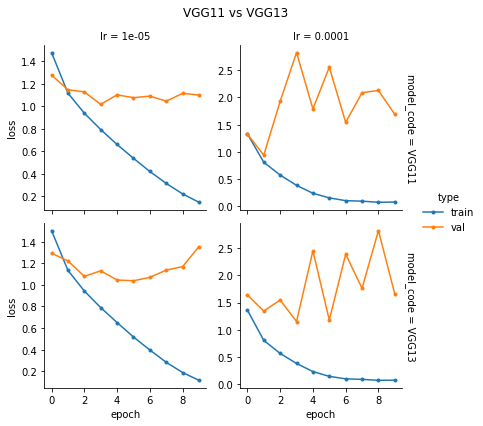

In [21]:
var1 = 'lr'
var2 = 'model_code'

df = load_exp_result('exp1_lr_model_code')
list_v1 = df[var1].unique()     # unique(): var1(n_layer)만 가져오겠다는 것
list_v2 = df[var2].unique()
# print(list_v1, list_v2)                   # [1, 2, 3], [300, 500]
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]      # 
        row = row.loc[df[var2]==value2]
        # print(value1, valuerow)
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)     # 어떤식으로 그래프를 그릴것인지 틀을 정의
g = g.map(plt.plot, 'epoch', 'loss', marker='.')        # g.map(): plt.plot인 각각의 서브 plot에서 실행 시킬것이다
g.add_legend()
g.fig.suptitle('VGG11 vs VGG13')
plt.subplots_adjust(top=0.89)